In [1]:
using CHull2D
using FixedSizeArrays
using PyPlot

# Monotone Chain Algorithm

This notebook is a piece of a sequence of notebooks that discuss numerical convex hull algorithms. The goal of these algorithms is to take a set of points $P$ and output a set of extreme points $EP$ such that every point in $P$ is contained in $\text{co}(EP)$.

In this notebook we present the Monotone Chain algorithm -- also known as Andrew's algorithm.

## Introduction

This algorithm was first introduced by A.M. Andrew in 1979 in the paper "*Another Efficient Algorithm for Convex Hulls in Two Dimensions*." This algorithm also has $O(n \log n)$ complexity which again is mostly due to sorting. The algorithm will compute the convex hull by computing two pieces: an "upper" and "lower" hull. The upper hull is the piece of the hull you would see looking down from above and the lower hull is the piece of the hull you would see looking up from below. One benefit this algorithm has over the Graham scan is that it will only require us to sort according to x-value instead of by angle -- This is a computationally simpler problem.

## Algorithm

TODO: Reread some of this and rephrase some steps.

* First, sort points by their x-coordinates in ascending order. Let $x_{\text{min}}$ be the point with the smallest x-value, and likewise define $x_{\text{max}}$ as the point with the largest $x$-value.
* Second, split points into two categories based on whether they are above or below the line that runs from $x_{\text{min}}$ to $x_{\text{max}}$. The points above the line (including endpoints of line) will be referred to as $x_U$ and points below (including endpoints of line) will be referred to as $x_L$.
* Third, beginning with $x_{\text{min}}$ and iterating through points in $x_L$ in ascending order... This will build our lower hull
* Fourth, beginning with $x_{\text{max}}$ and iterating through points in $x_U$ in descending order... This will build our upper hull

### Part 1: Sort

Since we sort by x-coordinate, it is easy to just call out to the sorting function provided by your programming language -- Here we will simply call Julia's `sort`.

### Part 2: Split into two categories

We now need to split the points into our two categories: $x_L$ and $x_U$. We can do this by taking each x-coordinate and computing the y-coordinate that corresponded to being on the line between $x_L$ and $x_U$. If the y-coordinate of the point is above the line then it belongs to $x_U$ and if it is below then it belongs to $x_L$.

We write a function which splits the points into $x_L$ and $x_U$ below.

In [2]:
function split_xL_xU{T<:Real}(psort::Vector{Point{2, T}})
    # Allocate space to identify where points belong
    # We make endpoints true because we want them in both sets
    npts = length(psort)
    xL_bool = Array(Bool, npts)
    xL_bool[1] = true; xL_bool[end] = true
    xU_bool = Array(Bool, npts)
    xU_bool[1] = true; xU_bool[end] = true

    # Get the endpoints and slope
    pmin = psort[1]; pmax = psort[end]
    ls = LineSegment(pmin, pmax)

    # We check whether it is above or below the line between
    # the points, but could also check whether it was clockwise
    # or counter-clockwise (above/below seems like less operations)
    # Iterate through all points except endpoints
    @inbounds for i=2:npts-1
        # Pull out x and y values for ith point
        p_i = psort[i]
        xi, yi = p_i[1], p_i[2]

        # Compute where y on line would be
        yi_line = evaluatey(ls, xi)

        if yi_line <= yi
            xL_bool[i] = false
            xU_bool[i] = true
        else
            xL_bool[i] = true
            xU_bool[i] = false
        end
    end
    xL = psort[xL_bool]
    xU = psort[xU_bool]

    return xL, xU
end


split_xL_xU (generic function with 1 method)

### Part 3 & 4: Finding Upper and Lower Hulls

In this step, we will use an approach that is similar to the Graham scan algorithm. If we are finding the upper (lower) hull then we will begin with $x_{\text{min}}$ ($x_{\text{max}}$) and work our way towards $x_{\text{max}}$ ($x_{\text{min}}$).

Just as in the Graham scan, we will need to identify the direction of the turn generated by three points. Imagine we have three points $p_{i-1}, p_{i}, p_{i+1}$.

* If these points constitute a counter-clockwise turn as desired then we proceed to compare points $p_{i}, p_{i+1}, p_{i+2}$.
* If these points constitute a clockwise turn then we know that $p_{i}$ is not an element of the extreme points and can discard it. We would then "take a step backwards" and compare $p_{i-2}, p_{i-1}, p_{i+1}$

We follow until we reach the end point which will be $x_{\text{max}}$ when we are finding the lower hull and $x_{\text{min}}$ when we are finding the upper hull.

Notice that this is the same function from the [convex hull notebook](ConvexHulls.ipynb) that we used in the Graham scan algorithm.

## Implementation

We can combine the previous steps into this short function which will compute the convex hull using the monotone chain algorithm.

In [3]:
function _monotonechain{T<:Real}(p::Vector{Point{2, T}})

    # Sort points
    psort = sort!(p)

    # Split into upper and lower
    xl, xu = split_xL_xU(psort)

    lh = wrappoints(xl)
    uh = wrappoints(reverse!(xu))

    return [lh[1:end-1]; uh[1:end-1]]
end


_monotonechain (generic function with 1 method)

## Example Usage

We can now do a simple example of how this function would be called.

In [4]:
srand(1112016)
p = [Point(randn(), randn()) for i=1:250]
ep = _monotonechain(p)

# Add the first point to end to make plot pretty
push!(ep, ep[1]);

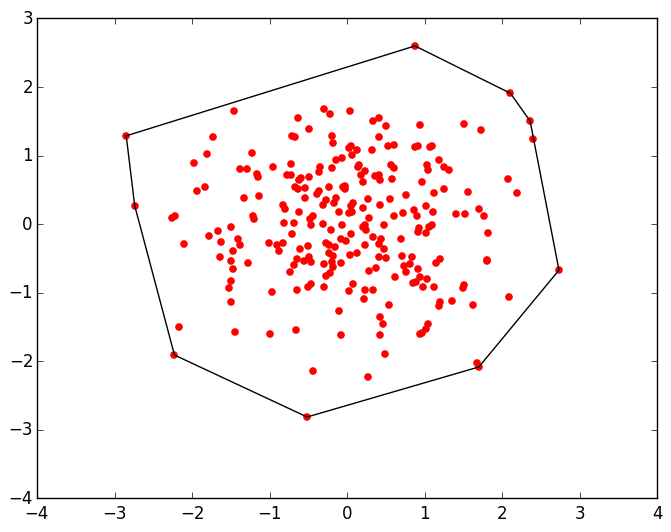

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5a69ccb690>

/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [5]:
fig, ax = subplots()

ax[:scatter]([el[1] for el in p], [el[2] for el in p], color="r")
ax[:plot]([el[1] for el in ep], [el[2] for el in ep], color="k")


## References

* A. M. Andrew, "*Another Efficient Algorithm for Convex Hulls in Two Dimensions*", Info. Proc. Letters 9, 216-219 (1979).